In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Aim :
1) Build a modular vision model with shared base features and multiple specialized processing units. Explain : what and how
2) Implement a dynamic routing mechanism that selects appropriate expert modules based on input data characteristics. Explain : What and how
3) Ensure that the model supports at least two tasks concurrently (e.g., disease grading classification and lesion segmentation).
Dataset : IDRiD (Indian Diabetic Retinopathy Image Dataset)

First since dataset is structure in a peculiar manner, I am creating a consolidated json file for segmentation task, ex:  [{image, "HE", "EX", "SE","OD""}].

In [2]:
import os
import json
from pathlib import Path


In [4]:


# === Config ===
base_dir = "/content/drive/MyDrive/idrid_dataset/A. Segmentation"
train_img_dir = Path(base_dir) / "1. Original Images" / "a. Training Set"

mask_base_dir = Path(base_dir) / "2. All Segmentation Groundtruths" / "a. Training Set"
lesion_dirs = {
    "MA": mask_base_dir / "1. Microaneurysms",
    "HE": mask_base_dir / "2. Haemorrhages",
    "EX": mask_base_dir / "3. Hard Exudates",
    "SE": mask_base_dir / "4. Soft Exudates",
    "OD": mask_base_dir / "5. Optic Disc"
}

#  Load all images
entries = []
for file in train_img_dir.glob("*.jpg"):
    image_id = file.stem  # Gets filename without extension
    entry = {
        "image": str(file.resolve())  # Absolute path with forward slashes
    }

    # Add each lesion mask path if available
    for lesion, dir_path in lesion_dirs.items():
        mask_filename = f"{image_id}_{lesion}.tif"
        mask_path = dir_path / mask_filename
        entry[lesion] = str(mask_path.resolve()) if mask_path.exists() else None

    entries.append(entry)


output_path = "segmentation_metadata_train.json"
with open(output_path, "w", encoding='utf-8') as f:  # utf-8 instead of utf-8-sig
    json.dump(entries, f, indent=4, ensure_ascii=False)  # ensure_ascii=False for proper path formatting

print(f" Saved {len(entries)} entries to {output_path}")
print(f"Sample entry: {json.dumps(entries[0], indent=2) if entries else 'No entries'}")

# Verify the JSON can be loaded back
try:
    with open(output_path, "r", encoding='utf-8') as f:
        test_load = json.load(f)
    print("JSON verification successful")
except Exception as e:
    print(f"JSON verification failed: {str(e)}")

 Saved 54 entries to segmentation_metadata_train.json
Sample entry: {
  "image": "/content/drive/MyDrive/idrid_dataset/A. Segmentation/1. Original Images/a. Training Set/IDRiD_37.jpg",
  "MA": "/content/drive/MyDrive/idrid_dataset/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/1. Microaneurysms/IDRiD_37_MA.tif",
  "HE": "/content/drive/MyDrive/idrid_dataset/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/2. Haemorrhages/IDRiD_37_HE.tif",
  "EX": "/content/drive/MyDrive/idrid_dataset/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/3. Hard Exudates/IDRiD_37_EX.tif",
  "SE": null,
  "OD": "/content/drive/MyDrive/idrid_dataset/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/5. Optic Disc/IDRiD_37_OD.tif"
}
JSON verification successful


#Visualize Segmentation

In [5]:
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path



def load_json_data(json_path):
    try:
        with open(json_path, 'r') as f:
            # First check if file is empty
            content = f.read().strip()
            if not content:
                raise ValueError("JSON file is empty")

            # Try to parse JSON
            try:
                data = json.loads(content)
            except json.JSONDecodeError as e:
                # Try to fix common trailing comma issue
                if content.endswith(','):
                    content = content[:-1]
                    data = json.loads(content)
                else:
                    raise e
        return data
    except Exception as e:
        print(f"Error loading JSON file: {e}")
        return None

json_path = "/content/segmentation_metadata_train.json"
data = load_json_data(json_path)

# Load JSON data
  # Replace with your actual JSON path
with open(json_path) as f:
    data = json.load(f)

# Color mapping for different segmentation classes bgr
seg_colors = {
    "MA": (0, 0, 255),      # Red - Microaneurysms
    "HE": (0, 255, 0),      # Green - Haemorrhages
    "EX": (255, 0, 0),      # Blue - Hard Exudates
    "SE": (0, 255, 255),    # Yellow - Soft Exudates
    "OD": (255, 0, 255)     # Magenta - Optic Disc
}

# Class descriptions for legend
class_descriptions = {
    "MA": "Microaneurysms",
    "HE": "Haemorrhages",
    "EX": "Hard Exudates",
    "SE": "Soft Exudates",
    "OD": "Optic Disc"
}


Visualizing: IDRiD_37.jpg


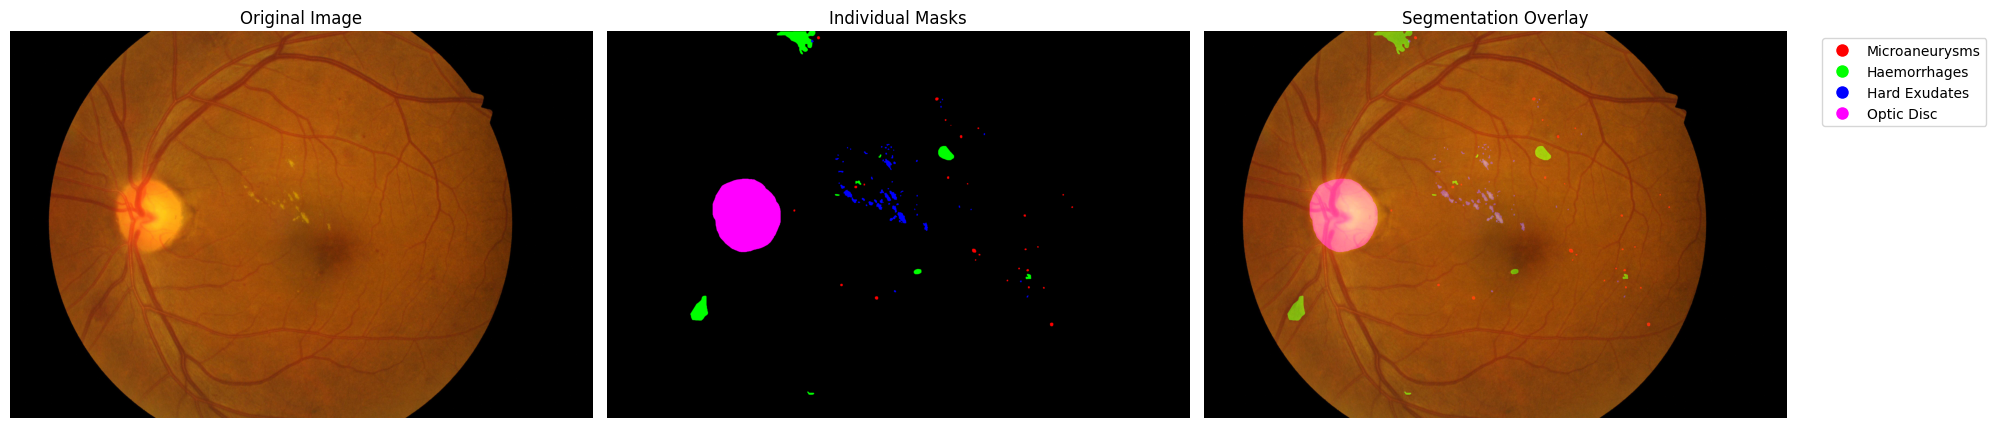


Visualizing: IDRiD_05.jpg


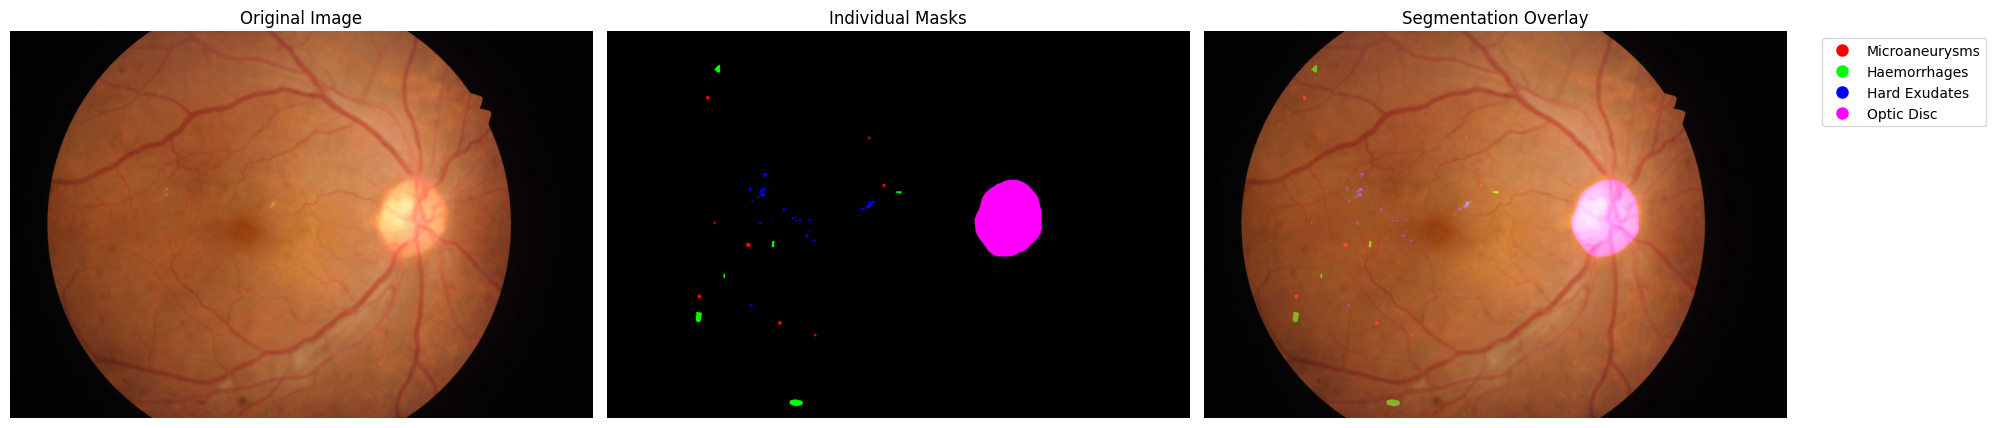


Visualizing: IDRiD_16.jpg


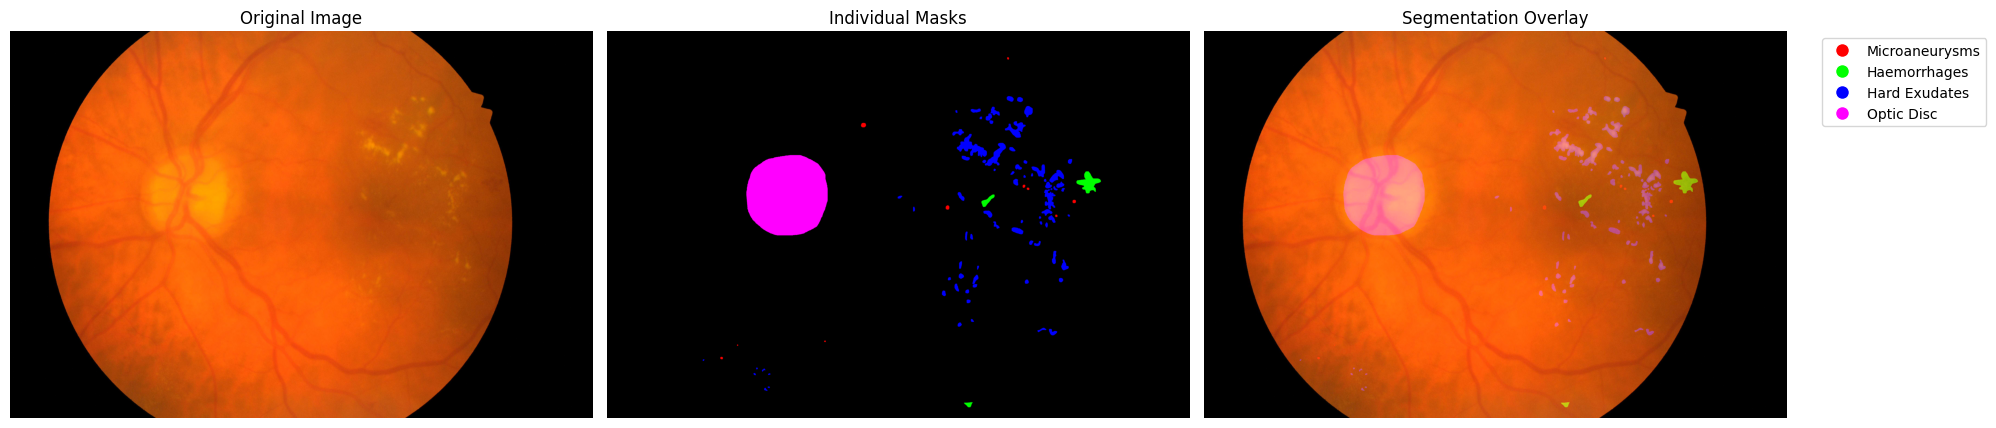


Visualizing: IDRiD_15.jpg


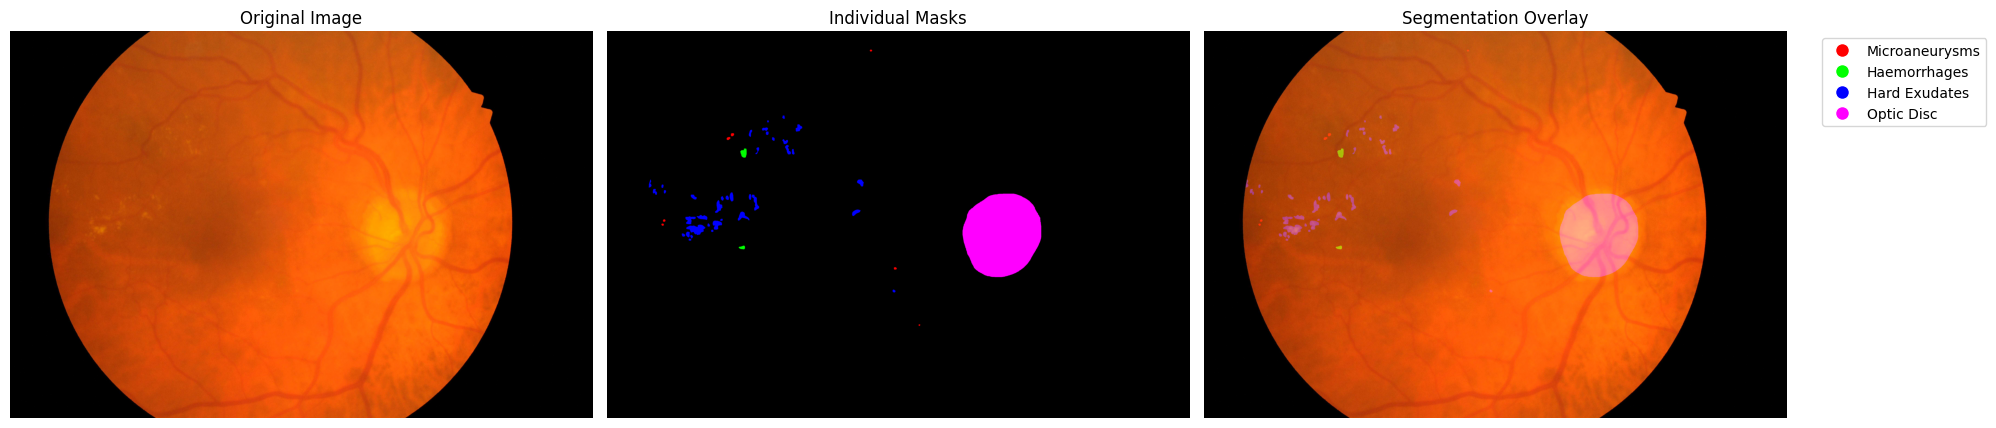


Visualizing: IDRiD_08.jpg


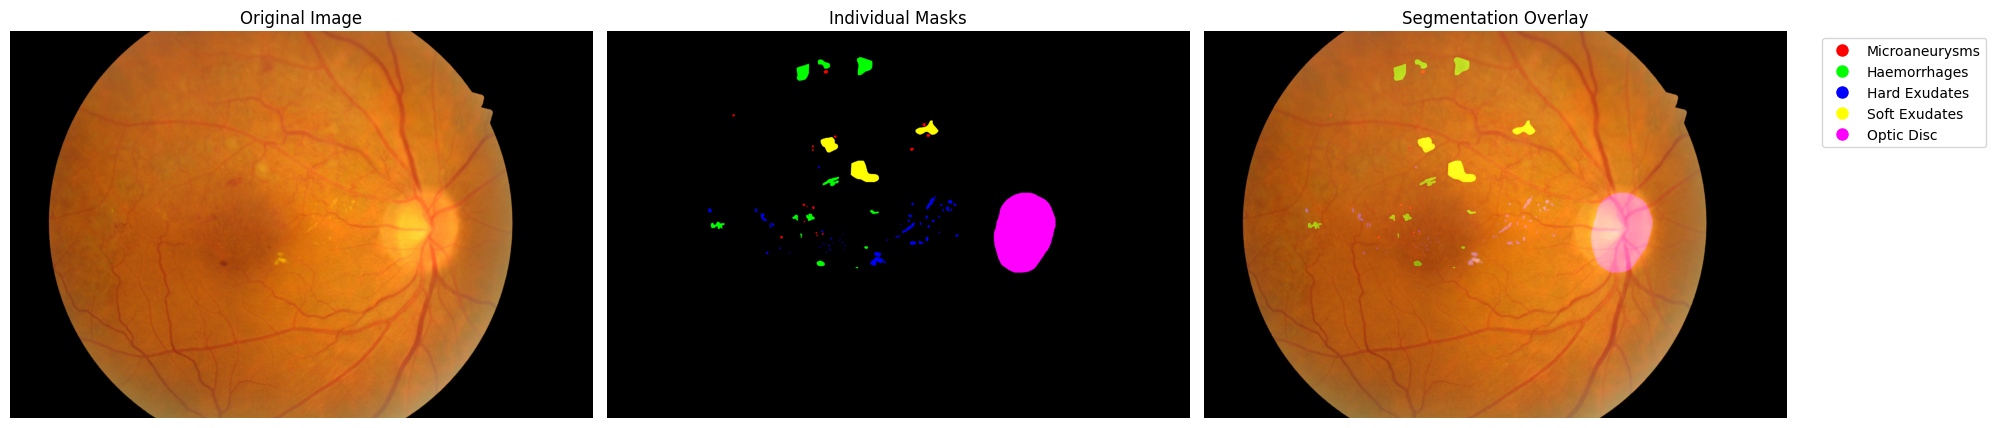

In [6]:

def visualize_sample(sample):
    # Load original image
    image_path = sample["image"]
    if not Path(image_path).exists():
        print(f"Image not found: {image_path}")
        return

    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not load image: {image_path}")
        return

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    overlay = image.copy()
    mask_display = np.zeros_like(image)

    # Create figure
    plt.figure(figsize=(20, 10))

    # Process each segmentation type
    for seg_type in ["MA", "HE", "EX", "SE", "OD"]:
        seg_path = sample[seg_type]

        # Skip if no mask for this type
        if seg_path is None:
            continue

        if not Path(seg_path).exists():
            print(f"Mask not found: {seg_path}")
            continue

        # Load mask (grayscale)
        mask = cv2.imread(seg_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"Could not load mask: {seg_path}")
            continue

        # Threshold mask to ensure binary
        _, binary_mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)

        # Get color for this segmentation type (convert BGR to RGB)
        color = seg_colors[seg_type][::-1]

        # Add to mask display (for individual mask visualization)
        mask_display[binary_mask > 0] = color

        # Create colored mask for overlay
        color_mask = np.zeros_like(image)
        color_mask[binary_mask > 0] = color

        # Overlay with transparency
        overlay = cv2.addWeighted(color_mask, 0.5, overlay, 1, 0)

    # Display original image
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')

    # Display individual masks
    plt.subplot(1, 3, 2)
    plt.imshow(mask_display)
    plt.title("Individual Masks")
    plt.axis('off')

    # Display overlay image
    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title("Segmentation Overlay")
    plt.axis('off')

    # Create legend
    legend_elements = []
    for seg_type, color in seg_colors.items():
        # Skip if this type wasn't present in the sample
        if sample[seg_type] is None:
            continue

        rgb_color = np.array(color[::-1]) / 255.0  # Convert to RGB and normalize
        legend_elements.append(
            plt.Line2D([0], [0], marker='o', color='w', label=class_descriptions[seg_type],
                      markerfacecolor=rgb_color, markersize=10)
        )

    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Visualize each sample in the JSON data
for sample in data[:5]:  # Visualize first 5 samples
    print(f"\nVisualizing: {Path(sample['image']).name}")
    visualize_sample(sample)

#segementation process :
Task definition - Given Image, network should be able to segment based on 5 classes : [Microaneurysms,Haemorrhages, Hard Exudates,Soft Exudates, Optic Disc]. And During prediction, use gradcam for visualization.
1) Create Dataloader - This will preproocess the data and handle null values.
2) Train Val - Creates train and validation sets.
3) Model  - Using Resnet50 trained on imagenet in a u-net structure for segementation.

In [38]:
!pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.1 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import segmentation_models_pytorch as smp
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import jaccard_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image

IMAGE_SIZE = (512, 512)
BATCH_SIZE = 4
NUM_CLASSES = 5
EPOCHS = 10
VAL_RATIO = 0.2
JSON_PATH ="/content/segmentation_metadata_train.json"
LOG_DIR = "./runs/idrid"
CLASS_NAMES = ['MA', 'HE', 'EX', 'SE', 'OD']
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Dataset
class IDRiDDataset(Dataset):
    def __init__(self, data, image_size=IMAGE_SIZE, is_train=True):
        self.data = data
        self.size = image_size
        self.classes = CLASS_NAMES
        self.image_tf = T.Compose([
            T.Resize(image_size),
            T.RandomHorizontalFlip(p=0.5) if is_train else T.Lambda(lambda x: x),
            T.ToTensor(),
            T.Normalize(mean=[0.5]*3, std=[0.5]*3)
        ])
        self.mask_tf = T.Resize(image_size)

    def __getitem__(self, idx):
        sample = self.data[idx]
        img = Image.open(sample['image']).convert('RGB')
        img = self.image_tf(img)

        masks = []
        for cls in self.classes:
            mask_path = sample.get(cls)
            if mask_path is None:
                mask = Image.fromarray(np.zeros(self.size, dtype=np.uint8))
            else:
                mask = Image.open(mask_path).convert('L')
            mask = self.mask_tf(mask)
            masks.append(torch.from_numpy(np.array(mask)).float() / 255.0)

        return img, torch.stack(masks)

    def __len__(self):
        return len(self.data)


In [ ]:
def load_data(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    train_data, val_data = train_test_split(data, test_size=VAL_RATIO, random_state=42)
    return train_data, val_data


Loss Function

In [ ]:
# Dice Loss
def dice_loss(pred, target, smooth=1.):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()


# Metrics
def compute_metrics(preds, targets):
    #preds = (torch.sigmoid(preds) > 0.5).cpu().numpy().astype(np.uint8)
    preds = (preds > 0.5).cpu().numpy().astype(np.uint8)
    targets = targets.cpu().numpy().astype(np.uint8)

    #targets = targets.cpu().numpy().astype(np.uint8)

    metrics = {'iou': [], 'precision': [], 'recall': []}
    for i in range(NUM_CLASSES):
        y_true = targets[:, i].reshape(-1)
        y_pred = preds[:, i].reshape(-1)
        metrics['iou'].append(jaccard_score(y_true, y_pred, zero_division=0))
        metrics['precision'].append(precision_score(y_true, y_pred, zero_division=0))
        metrics['recall'].append(recall_score(y_true, y_pred, zero_division=0))
    return metrics

In [ ]:
def visualize_batch(images, masks, writer, step, tag):
    img_grid = []
    for i in range(images.size(0)):
        image = images[i].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5
        fig, axs = plt.subplots(1, NUM_CLASSES + 1, figsize=(18, 3))
        axs[0].imshow(image)
        axs[0].set_title("Image")
        axs[0].axis("off")
        for j in range(NUM_CLASSES):
            axs[j+1].imshow(masks[i, j].cpu(), cmap='gray')
            axs[j+1].set_title(CLASS_NAMES[j])
            axs[j+1].axis("off")
        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        img_grid.append(torch.tensor(img).permute(2, 0, 1))
        plt.close()
    writer.add_images(tag, torch.stack(img_grid) / 255.0, global_step=step)


In [ ]:
if __name__ == "__main__":
    train_data, val_data = load_data(JSON_PATH)
    train_ds = IDRiDDataset(train_data, is_train=True)
    val_ds = IDRiDDataset(val_data, is_train=False)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    model = smp.Unet("resnet50", encoder_weights="imagenet", in_channels=3, classes=NUM_CLASSES).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    writer = SummaryWriter(LOG_DIR)

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        for images, masks in train_loader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)
            loss = dice_loss(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        all_preds, all_targets = [], []
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(DEVICE), masks.to(DEVICE)
                outputs = model(images)
                loss = dice_loss(outputs, masks)
                val_loss += loss.item()
                all_preds.append(outputs)
                all_targets.append(masks)

        # Metrics & Logging
        all_preds = torch.cat(all_preds)
        all_targets = torch.cat(all_targets)
        metrics = compute_metrics(all_preds, all_targets)

       # print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(
                  f"Epoch {epoch+1}/{EPOCHS} | "
                  f"Train Loss: {train_loss:.4f} | "
                  f"Val Loss: {val_loss:.4f} | "
                  f"IoU: {np.mean(metrics['iou']):.4f} | "
                  f"Precision: {np.mean(metrics['precision']):.4f} | "
                  f"Recall: {np.mean(metrics['recall']):.4f}"
              )

        writer.add_scalar("Loss/Train", train_loss, epoch)
        writer.add_scalar("Loss/Val", val_loss, epoch)
        for i, name in enumerate(CLASS_NAMES):
            writer.add_scalar(f"IoU/{name}", metrics['iou'][i], epoch)
            writer.add_scalar(f"Precision/{name}", metrics['precision'][i], epoch)
            writer.add_scalar(f"Recall/{name}", metrics['recall'][i], epoch)

        writer.add_scalar("IoU/Mean", np.mean(metrics['iou']), epoch)
        writer.add_scalar("Precision/Mean", np.mean(metrics['precision']), epoch)
        writer.add_scalar("Recall/Mean", np.mean(metrics['recall']), epoch)

        # Visual logging (first batch only)


    writer.close()

Epoch 1/10 | Train Loss: 5.9631 | Val Loss: 1.9917 | IoU: 0.0000 | Precision: 0.0000 | Recall: 0.0000
Epoch 2/10 | Train Loss: 5.9594 | Val Loss: 1.9906 | IoU: 0.0000 | Precision: 0.0000 | Recall: 0.0000
Epoch 3/10 | Train Loss: 5.9561 | Val Loss: 1.9890 | IoU: 0.0000 | Precision: 0.0000 | Recall: 0.0000
Epoch 4/10 | Train Loss: 5.9546 | Val Loss: 1.9872 | IoU: 0.0000 | Precision: 0.0000 | Recall: 0.0000
Epoch 5/10 | Train Loss: 5.9496 | Val Loss: 1.9862 | IoU: 0.0000 | Precision: 0.0000 | Recall: 0.0000
Epoch 6/10 | Train Loss: 5.9511 | Val Loss: 1.9864 | IoU: 0.0000 | Precision: 0.0000 | Recall: 0.0000
Epoch 7/10 | Train Loss: 5.9445 | Val Loss: 1.9849 | IoU: 0.0000 | Precision: 0.0000 | Recall: 0.0000
Epoch 8/10 | Train Loss: 5.9401 | Val Loss: 1.9839 | IoU: 0.0000 | Precision: 0.0000 | Recall: 0.0000
Epoch 9/10 | Train Loss: 5.9330 | Val Loss: 1.9854 | IoU: 0.0000 | Precision: 0.0000 | Recall: 0.0000
Epoch 10/10 | Train Loss: 5.9360 | Val Loss: 1.9847 | IoU: 0.0000 | Precision: 0.0

In [ ]:
torch.save(model.state_dict(), "unet_idrid.pth")


In [ ]:
torch.save(model, "unet_idrid_full.pt")

In [ ]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import jaccard_score, precision_score, recall_score
import segmentation_models_pytorch as smp

#from idrid_train import IDRiDDataset, load_data, CLASS_NAMES, IMAGE_SIZE, VAL_RATIO, JSON_PATH, BATCH_SIZE



IMAGE_SIZE = (512, 512)
BATCH_SIZE = 4
NUM_CLASSES = 5
EPOCHS = 10
VAL_RATIO = 0.2
JSON_PATH ="/content/segmentation_metadata_test.json"
LOG_DIR = "./runs/idrid"
CLASS_NAMES = ['MA', 'HE', 'EX', 'SE', 'OD']
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_data(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    train_data, val_data = train_test_split(data, test_size=VAL_RATIO, random_state=42)
    return train_data, val_data


# Load validation set
_, val_data = load_data(JSON_PATH)
val_ds = IDRiDDataset(val_data, image_size=IMAGE_SIZE, is_train=False)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

# Load trained model
model = smp.Unet("resnet50", encoder_weights=None, in_channels=3, classes=len(CLASS_NAMES))
model.load_state_dict(torch.load("/content/unet_idrid.pth", map_location=DEVICE))
model.to(DEVICE)
model.eval()

# Metrics
all_preds, all_targets = [], []

with torch.no_grad():
    for imgs, masks in val_loader:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        preds = model(imgs)
        all_preds.append(torch.sigmoid(preds).cpu())
        all_targets.append(masks.cpu())

preds = torch.cat(all_preds)
targets = torch.cat(all_targets)

def compute_metrics(preds, targets):
    preds = (preds > 0.5).numpy().astype(np.uint8)
    targets = targets.numpy().astype(np.uint8)

    ious, precs, recs = [], [], []
    for i in range(preds.shape[1]):
        y_pred = preds[:, i].reshape(-1)
        y_true = targets[:, i].reshape(-1)
        ious.append(jaccard_score(y_true, y_pred, zero_division=0))
        precs.append(precision_score(y_true, y_pred, zero_division=0))
        recs.append(recall_score(y_true, y_pred, zero_division=0))

    print("📊 Evaluation Metrics:")
    for i, name in enumerate(CLASS_NAMES):
        print(f"  {name:<2} | IoU: {ious[i]:.4f} | Precision: {precs[i]:.4f} | Recall: {recs[i]:.4f}")
    print(f"\n⭐ Mean IoU: {np.mean(ious):.4f} | Mean Precision: {np.mean(precs):.4f} | Mean Recall: {np.mean(recs):.4f}")

compute_metrics(preds, targets)

📊 Evaluation Metrics:
  MA | IoU: 0.0000 | Precision: 0.0000 | Recall: 0.0000
  HE | IoU: 0.0000 | Precision: 0.0000 | Recall: 0.0000
  EX | IoU: 0.0000 | Precision: 0.0000 | Recall: 0.0000
  SE | IoU: 0.0000 | Precision: 0.0000 | Recall: 0.0000
  OD | IoU: 0.0000 | Precision: 0.0000 | Recall: 0.0000

⭐ Mean IoU: 0.0000 | Mean Precision: 0.0000 | Mean Recall: 0.0000


___________________________________________ new dataloader ____________________

In [17]:
import torchmetrics as tm
print(tm.__version__)
from torchmetrics.segmentation import DiceScore, dice

1.7.3


/tmp/ipython-input-25-1142796558.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, torch.tensor(mask_stack).permute(2, 0, 1)


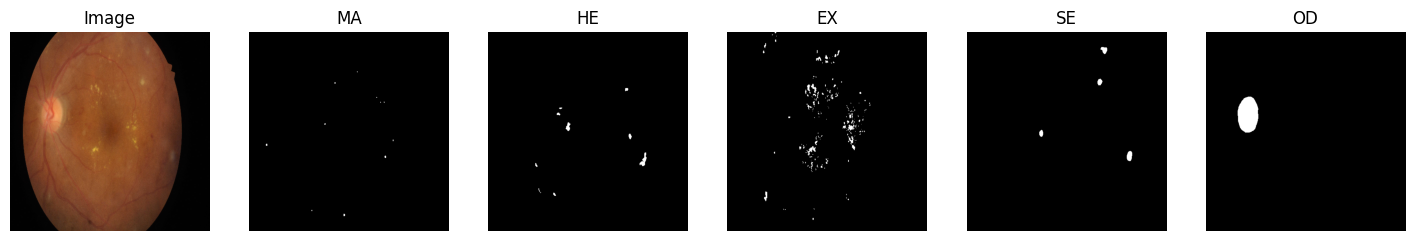

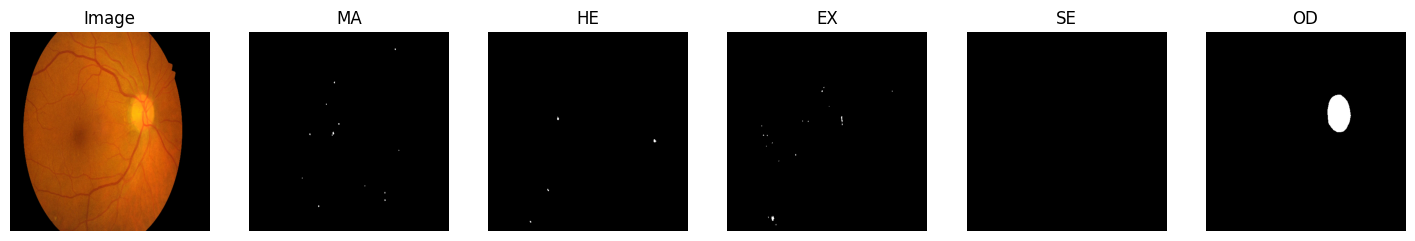

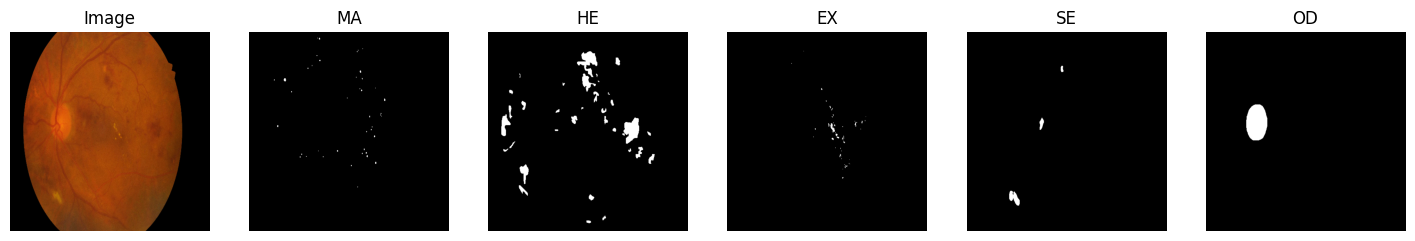

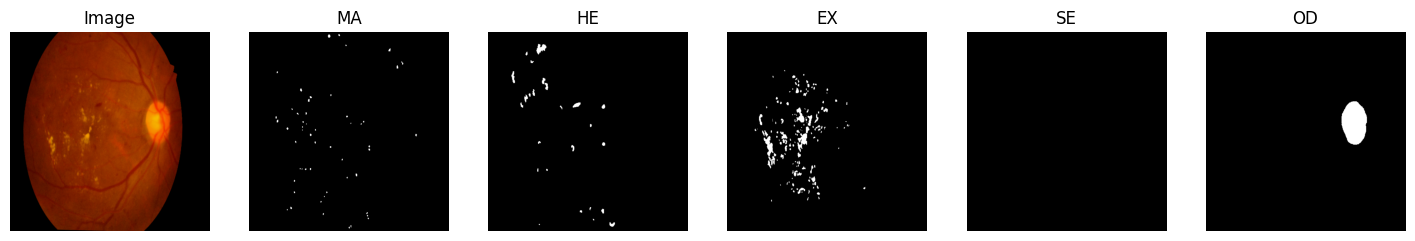

Before thresholding:
  Preds min/max: 9.019726712722331e-05 0.9994935989379883
  Targets min/max: 0.0 1.0
After thresholding:
  Predicted foreground pixels: 4513197
  Ground truth foreground pixels: 99273
Epoch 1/35 | Train Loss: 18.0798 | Val Loss: 2.9411 | IoU: 0.0178


/tmp/ipython-input-25-1142796558.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, torch.tensor(mask_stack).permute(2, 0, 1)


Before thresholding:
  Preds min/max: 6.62692445985158e-06 0.9999580383300781
  Targets min/max: 0.0 1.0
After thresholding:
  Predicted foreground pixels: 3578158
  Ground truth foreground pixels: 99280
Epoch 2/35 | Train Loss: 17.3521 | Val Loss: 2.9314 | IoU: 0.0239


/tmp/ipython-input-25-1142796558.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, torch.tensor(mask_stack).permute(2, 0, 1)


Before thresholding:
  Preds min/max: 2.560501525294967e-05 0.9998395442962646
  Targets min/max: 0.0 1.0
After thresholding:
  Predicted foreground pixels: 1839848
  Ground truth foreground pixels: 99273
Epoch 3/35 | Train Loss: 16.8497 | Val Loss: 2.9311 | IoU: 0.0417


/tmp/ipython-input-25-1142796558.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, torch.tensor(mask_stack).permute(2, 0, 1)


Before thresholding:
  Preds min/max: 2.9771297704428434e-05 0.9993258714675903
  Targets min/max: 0.0 1.0
After thresholding:
  Predicted foreground pixels: 1195443
  Ground truth foreground pixels: 99275
Epoch 4/35 | Train Loss: 16.4527 | Val Loss: 2.9308 | IoU: 0.0614


/tmp/ipython-input-25-1142796558.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, torch.tensor(mask_stack).permute(2, 0, 1)


Before thresholding:
  Preds min/max: 0.00014677252329420298 0.9964583516120911
  Targets min/max: 0.0 1.0
After thresholding:
  Predicted foreground pixels: 786881
  Ground truth foreground pixels: 99276
Epoch 5/35 | Train Loss: 16.1196 | Val Loss: 2.9296 | IoU: 0.1077


/tmp/ipython-input-25-1142796558.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, torch.tensor(mask_stack).permute(2, 0, 1)


Before thresholding:
  Preds min/max: 0.0007390001555904746 0.9845742583274841
  Targets min/max: 0.0 1.0
After thresholding:
  Predicted foreground pixels: 612642
  Ground truth foreground pixels: 99277
Epoch 6/35 | Train Loss: 15.8137 | Val Loss: 2.9303 | IoU: 0.1324


/tmp/ipython-input-25-1142796558.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, torch.tensor(mask_stack).permute(2, 0, 1)


Before thresholding:
  Preds min/max: 0.00113836326636374 0.9750037789344788
  Targets min/max: 0.0 1.0
After thresholding:
  Predicted foreground pixels: 470390
  Ground truth foreground pixels: 99274
Epoch 7/35 | Train Loss: 15.5398 | Val Loss: 2.9301 | IoU: 0.1301


/tmp/ipython-input-25-1142796558.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, torch.tensor(mask_stack).permute(2, 0, 1)


Before thresholding:
  Preds min/max: 0.0032366756349802017 0.948648989200592
  Targets min/max: 0.0 1.0
After thresholding:
  Predicted foreground pixels: 364620
  Ground truth foreground pixels: 99275
Epoch 8/35 | Train Loss: 15.2850 | Val Loss: 2.9291 | IoU: 0.1602


/tmp/ipython-input-25-1142796558.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, torch.tensor(mask_stack).permute(2, 0, 1)


Before thresholding:
  Preds min/max: 0.0031205841805785894 0.9392991065979004
  Targets min/max: 0.0 1.0
After thresholding:
  Predicted foreground pixels: 244810
  Ground truth foreground pixels: 99243
Epoch 9/35 | Train Loss: 15.0480 | Val Loss: 2.9271 | IoU: 0.1617


/tmp/ipython-input-25-1142796558.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, torch.tensor(mask_stack).permute(2, 0, 1)


Before thresholding:
  Preds min/max: 0.0036960295401513577 0.9349032044410706
  Targets min/max: 0.0 1.0
After thresholding:
  Predicted foreground pixels: 163846
  Ground truth foreground pixels: 99263
Epoch 10/35 | Train Loss: 14.8176 | Val Loss: 2.9253 | IoU: 0.1768


/tmp/ipython-input-25-1142796558.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, torch.tensor(mask_stack).permute(2, 0, 1)


Before thresholding:
  Preds min/max: 0.005422662012279034 0.9079016447067261
  Targets min/max: 0.0 1.0
After thresholding:
  Predicted foreground pixels: 121301
  Ground truth foreground pixels: 99276
Epoch 11/35 | Train Loss: 14.5954 | Val Loss: 2.9243 | IoU: 0.1600


/tmp/ipython-input-25-1142796558.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, torch.tensor(mask_stack).permute(2, 0, 1)


Before thresholding:
  Preds min/max: 0.006180248688906431 0.912892758846283
  Targets min/max: 0.0 1.0
After thresholding:
  Predicted foreground pixels: 100856
  Ground truth foreground pixels: 99272
Epoch 12/35 | Train Loss: 14.3813 | Val Loss: 2.9202 | IoU: 0.1829


/tmp/ipython-input-25-1142796558.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, torch.tensor(mask_stack).permute(2, 0, 1)


Before thresholding:
  Preds min/max: 0.010611891746520996 0.897467851638794
  Targets min/max: 0.0 1.0
After thresholding:
  Predicted foreground pixels: 90043
  Ground truth foreground pixels: 99273
Epoch 13/35 | Train Loss: 14.1800 | Val Loss: 2.9177 | IoU: 0.2050


/tmp/ipython-input-25-1142796558.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, torch.tensor(mask_stack).permute(2, 0, 1)


Before thresholding:
  Preds min/max: 0.008960668928921223 0.9129592180252075
  Targets min/max: 0.0 1.0
After thresholding:
  Predicted foreground pixels: 99861
  Ground truth foreground pixels: 99275
Epoch 14/35 | Train Loss: 13.9755 | Val Loss: 2.9119 | IoU: 0.1983


/tmp/ipython-input-25-1142796558.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, torch.tensor(mask_stack).permute(2, 0, 1)


Before thresholding:
  Preds min/max: 0.015509996563196182 0.8971304893493652
  Targets min/max: 0.0 1.0
After thresholding:
  Predicted foreground pixels: 92794
  Ground truth foreground pixels: 99279
Epoch 15/35 | Train Loss: 13.7807 | Val Loss: 2.9082 | IoU: 0.2158


/tmp/ipython-input-25-1142796558.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, torch.tensor(mask_stack).permute(2, 0, 1)


Before thresholding:
  Preds min/max: 0.01743094064295292 0.903441309928894
  Targets min/max: 0.0 1.0
After thresholding:
  Predicted foreground pixels: 92895
  Ground truth foreground pixels: 99284
Epoch 16/35 | Train Loss: 13.5873 | Val Loss: 2.9037 | IoU: 0.2142


/tmp/ipython-input-25-1142796558.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, torch.tensor(mask_stack).permute(2, 0, 1)


Before thresholding:
  Preds min/max: 0.01287365797907114 0.9380820989608765
  Targets min/max: 0.0 1.0
After thresholding:
  Predicted foreground pixels: 90402
  Ground truth foreground pixels: 99269
Epoch 17/35 | Train Loss: 13.4062 | Val Loss: 2.8973 | IoU: 0.2233


/tmp/ipython-input-25-1142796558.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, torch.tensor(mask_stack).permute(2, 0, 1)


Before thresholding:
  Preds min/max: 0.012363173998892307 0.9448358416557312
  Targets min/max: 0.0 1.0
After thresholding:
  Predicted foreground pixels: 89182
  Ground truth foreground pixels: 99276
Epoch 18/35 | Train Loss: 13.2314 | Val Loss: 2.8933 | IoU: 0.2300


/tmp/ipython-input-25-1142796558.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, torch.tensor(mask_stack).permute(2, 0, 1)


Before thresholding:
  Preds min/max: 0.010708943009376526 0.9611716270446777
  Targets min/max: 0.0 1.0
After thresholding:
  Predicted foreground pixels: 92906
  Ground truth foreground pixels: 99269
Epoch 19/35 | Train Loss: 13.0730 | Val Loss: 2.8858 | IoU: 0.2288


/tmp/ipython-input-25-1142796558.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, torch.tensor(mask_stack).permute(2, 0, 1)


Before thresholding:
  Preds min/max: 0.010009081102907658 0.9737870693206787
  Targets min/max: 0.0 1.0
After thresholding:
  Predicted foreground pixels: 81466
  Ground truth foreground pixels: 99270
Epoch 20/35 | Train Loss: 12.9194 | Val Loss: 2.8832 | IoU: 0.2423


/tmp/ipython-input-25-1142796558.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, torch.tensor(mask_stack).permute(2, 0, 1)


Before thresholding:
  Preds min/max: 0.008808831684291363 0.9751443266868591
  Targets min/max: 0.0 1.0
After thresholding:
  Predicted foreground pixels: 85781
  Ground truth foreground pixels: 99271
Epoch 21/35 | Train Loss: 12.7697 | Val Loss: 2.8733 | IoU: 0.2464


/tmp/ipython-input-25-1142796558.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, torch.tensor(mask_stack).permute(2, 0, 1)


Before thresholding:
  Preds min/max: 0.00702267000451684 0.9805877804756165
  Targets min/max: 0.0 1.0
After thresholding:
  Predicted foreground pixels: 92056
  Ground truth foreground pixels: 99269
Epoch 22/35 | Train Loss: 12.6273 | Val Loss: 2.8619 | IoU: 0.2305


/tmp/ipython-input-25-1142796558.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, torch.tensor(mask_stack).permute(2, 0, 1)


Before thresholding:
  Preds min/max: 0.007052933797240257 0.9823499917984009
  Targets min/max: 0.0 1.0
After thresholding:
  Predicted foreground pixels: 90891
  Ground truth foreground pixels: 99274
Epoch 23/35 | Train Loss: 12.4888 | Val Loss: 2.8589 | IoU: 0.2418


/tmp/ipython-input-25-1142796558.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, torch.tensor(mask_stack).permute(2, 0, 1)


Before thresholding:
  Preds min/max: 0.00452205678448081 0.9839805364608765
  Targets min/max: 0.0 1.0
After thresholding:
  Predicted foreground pixels: 79969
  Ground truth foreground pixels: 99280
Epoch 24/35 | Train Loss: 12.3469 | Val Loss: 2.8511 | IoU: 0.2391


/tmp/ipython-input-25-1142796558.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, torch.tensor(mask_stack).permute(2, 0, 1)


Before thresholding:
  Preds min/max: 0.004051231313496828 0.9850332140922546
  Targets min/max: 0.0 1.0
After thresholding:
  Predicted foreground pixels: 84262
  Ground truth foreground pixels: 99273
Epoch 25/35 | Train Loss: 12.2174 | Val Loss: 2.8412 | IoU: 0.2364


/tmp/ipython-input-25-1142796558.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, torch.tensor(mask_stack).permute(2, 0, 1)


Before thresholding:
  Preds min/max: 0.0032079676166176796 0.9880571365356445
  Targets min/max: 0.0 1.0
After thresholding:
  Predicted foreground pixels: 98971
  Ground truth foreground pixels: 99273
Epoch 26/35 | Train Loss: 12.0950 | Val Loss: 2.8233 | IoU: 0.2204


/tmp/ipython-input-25-1142796558.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, torch.tensor(mask_stack).permute(2, 0, 1)


Before thresholding:
  Preds min/max: 0.003522230079397559 0.9876219630241394
  Targets min/max: 0.0 1.0
After thresholding:
  Predicted foreground pixels: 85943
  Ground truth foreground pixels: 99270
Epoch 27/35 | Train Loss: 11.9684 | Val Loss: 2.8199 | IoU: 0.2490


/tmp/ipython-input-25-1142796558.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, torch.tensor(mask_stack).permute(2, 0, 1)


Before thresholding:
  Preds min/max: 0.00256421510130167 0.988811731338501
  Targets min/max: 0.0 1.0
After thresholding:
  Predicted foreground pixels: 85177
  Ground truth foreground pixels: 99275
Epoch 28/35 | Train Loss: 11.8292 | Val Loss: 2.8110 | IoU: 0.2772


/tmp/ipython-input-25-1142796558.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, torch.tensor(mask_stack).permute(2, 0, 1)


Before thresholding:
  Preds min/max: 0.002350802533328533 0.9884524941444397
  Targets min/max: 0.0 1.0
After thresholding:
  Predicted foreground pixels: 90228
  Ground truth foreground pixels: 99272
Epoch 29/35 | Train Loss: 11.6967 | Val Loss: 2.8028 | IoU: 0.2972


/tmp/ipython-input-25-1142796558.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, torch.tensor(mask_stack).permute(2, 0, 1)


Before thresholding:
  Preds min/max: 0.001950137666426599 0.9883621335029602
  Targets min/max: 0.0 1.0
After thresholding:
  Predicted foreground pixels: 101003
  Ground truth foreground pixels: 99265
Epoch 30/35 | Train Loss: 11.5843 | Val Loss: 2.7850 | IoU: 0.2727


/tmp/ipython-input-25-1142796558.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, torch.tensor(mask_stack).permute(2, 0, 1)


Before thresholding:
  Preds min/max: 0.0018717633793130517 0.9865580201148987
  Targets min/max: 0.0 1.0
After thresholding:
  Predicted foreground pixels: 95274
  Ground truth foreground pixels: 99268
Epoch 31/35 | Train Loss: 11.4654 | Val Loss: 2.7748 | IoU: 0.2867


/tmp/ipython-input-25-1142796558.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, torch.tensor(mask_stack).permute(2, 0, 1)


Before thresholding:
  Preds min/max: 0.0013933576410636306 0.9903939366340637
  Targets min/max: 0.0 1.0
After thresholding:
  Predicted foreground pixels: 104244
  Ground truth foreground pixels: 99277
Epoch 32/35 | Train Loss: 11.3402 | Val Loss: 2.7552 | IoU: 0.3103


/tmp/ipython-input-25-1142796558.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, torch.tensor(mask_stack).permute(2, 0, 1)


Before thresholding:
  Preds min/max: 0.0014964538859203458 0.9911433458328247
  Targets min/max: 0.0 1.0
After thresholding:
  Predicted foreground pixels: 94790
  Ground truth foreground pixels: 99274
Epoch 33/35 | Train Loss: 11.2077 | Val Loss: 2.7457 | IoU: 0.3100


/tmp/ipython-input-25-1142796558.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, torch.tensor(mask_stack).permute(2, 0, 1)


Before thresholding:
  Preds min/max: 0.0014968764735385776 0.9908255934715271
  Targets min/max: 0.0 1.0
After thresholding:
  Predicted foreground pixels: 91610
  Ground truth foreground pixels: 99272
Epoch 34/35 | Train Loss: 11.0977 | Val Loss: 2.7367 | IoU: 0.3061


/tmp/ipython-input-25-1142796558.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, torch.tensor(mask_stack).permute(2, 0, 1)


Before thresholding:
  Preds min/max: 0.0008477268274873495 0.9939256310462952
  Targets min/max: 0.0 1.0
After thresholding:
  Predicted foreground pixels: 94625
  Ground truth foreground pixels: 99277
Epoch 35/35 | Train Loss: 10.9933 | Val Loss: 2.7205 | IoU: 0.3114


In [25]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, precision_score, recall_score, accuracy_score
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

# ---------------------------
# CONFIGURATION
# ---------------------------
IMAGE_SIZE = (512, 512)
BATCH_SIZE = 4
NUM_CLASSES = 5
EPOCHS = 35
VAL_RATIO = 0.2
JSON_PATH = "/content/segmentation_metadata_train.json"
LOG_DIR = "./runs/idrid"
MODEL_PATH = "/content/drive/MyDrive/best_model_combined_loss2.pth"
CLASS_NAMES = ['MA', 'HE', 'EX', 'SE', 'OD']
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------
# DATASET
# ---------------------------
class IDRiDDataset(Dataset):
    def __init__(self, data, image_size=IMAGE_SIZE, is_train=True):
        self.data = data
        self.size = image_size
        self.classes = CLASS_NAMES
        self.is_train = is_train
        self.aug = A.Compose([
            A.Resize(height=self.size[0], width=self.size[1]),
            A.RandomBrightnessContrast(p=0.5),
            A.Rotate(limit=3, p=0.3),  # small angle rotation, commented by default
            A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
            ToTensorV2()
        ])

    def __getitem__(self, idx):
        sample = self.data[idx]
        img = np.array(Image.open(sample['image']).convert('RGB'))

        masks = []
        for cls in self.classes:
            mask_path = sample.get(cls)
            if mask_path is None:
                mask = np.zeros_like(img[:, :, 0], dtype=np.uint8)  # use image shape
            else:
                mask = np.array(Image.open(mask_path).convert('L'))
            mask = (mask > 0).astype(np.float32)
            masks.append(mask)

        mask_stack = np.stack(masks, axis=-1)

        if self.is_train:
            augmented = self.aug(image=img, mask=mask_stack)
            img = augmented['image']
            mask_stack = augmented['mask']
        else:
            augmented = self.aug(image=img, mask=mask_stack)
            img = augmented['image']
            mask_stack = augmented['mask']

        return img, torch.tensor(mask_stack).permute(2, 0, 1)

    def __len__(self):
        return len(self.data)
# ---------------------------
# UTILITY FUNCTIONS
# ---------------------------
def load_data(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def dice_loss(pred, target, smooth=1.):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

def combined_loss(pred, target, smooth=1.):
    bce = F.binary_cross_entropy_with_logits(pred, target)
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice.mean() + bce

def compute_metrics_(preds, targets):
    preds = torch.sigmoid(preds) > 0.5
    preds = preds.cpu().numpy().astype(np.uint8)
    targets = targets.cpu().numpy().astype(np.uint8)

    metrics = {'iou': [], 'precision': [], 'recall': []}
    for i in range(NUM_CLASSES):
        y_true = targets[:, i].reshape(-1)
        y_pred = preds[:, i].reshape(-1)
        metrics['iou'].append(jaccard_score(y_true, y_pred, zero_division=0))
        metrics['precision'].append(precision_score(y_true, y_pred, zero_division=0))
        metrics['recall'].append(recall_score(y_true, y_pred, zero_division=0))
    return metrics

def compute_metrics(preds, targets):
    # Apply sigmoid and threshold
    preds = torch.sigmoid(preds)
    print("Before thresholding:")
    print("  Preds min/max:", preds.min().item(), preds.max().item())
    print("  Targets min/max:", targets.min().item(), targets.max().item())

    preds = preds > 0.5
    preds = preds.cpu().numpy().astype(np.uint8)
    targets = targets.cpu().numpy().astype(np.uint8)

    print("After thresholding:")
    print("  Predicted foreground pixels:", preds.sum())
    print("  Ground truth foreground pixels:", targets.sum())

    metrics = {'iou': [], 'precision': [], 'recall': []}
    for i in range(NUM_CLASSES):
        y_true = targets[:, i].reshape(-1)
        y_pred = preds[:, i].reshape(-1)
        metrics['iou'].append(jaccard_score(y_true, y_pred, zero_division=0))
        metrics['precision'].append(precision_score(y_true, y_pred, zero_division=0))
        metrics['recall'].append(recall_score(y_true, y_pred, zero_division=0))
    return metrics


def visualize_batch_(images, masks, writer, step, tag):
    img_grid = []
    for i in range(images.size(0)):
        image = images[i].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5
        fig, axs = plt.subplots(1, NUM_CLASSES + 1, figsize=(18, 3))
        canvas = FigureCanvas(fig)
        axs[0].imshow(image)
        axs[0].set_title("Image")
        axs[0].axis("off")
        for j in range(NUM_CLASSES):
            axs[j+1].imshow(masks[i, j].cpu(), cmap='gray')
            axs[j+1].set_title(CLASS_NAMES[j])
            axs[j+1].axis("off")
        canvas.draw()
        img = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
        img = img.reshape(canvas.get_width_height()[::-1] + (3,))
        img_grid.append(torch.tensor(img).permute(2, 0, 1))
        plt.close()
    writer.add_images(tag, torch.stack(img_grid) / 255.0, global_step=step)
def visualize_batch(images, masks):
    for i in range(images.size(0)):
        image = images[i].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5
        fig, axs = plt.subplots(1, len(CLASS_NAMES) + 1, figsize=(18, 3))
        canvas = FigureCanvas(fig)
        axs[0].imshow(image)
        axs[0].set_title("Image")
        axs[0].axis("off")
        for j in range(len(CLASS_NAMES)):
            axs[j+1].imshow(masks[i, j].cpu(), cmap='gray')
            axs[j+1].set_title(CLASS_NAMES[j])
            axs[j+1].axis("off")
        plt.show()
        plt.close()

# ---------------------------
# PREDICTION DUMMY FUNCTION
# ---------------------------
def predict(image_tensor, model):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(DEVICE).unsqueeze(0)  # Add batch dim
        output = model(image_tensor)
        output = torch.sigmoid(output).squeeze(0).cpu()

        gradcam_placeholder = None
        return output, gradcam_placeholder

# ---------------------------
# SIMPLE TRAINING LOOP
# ---------------------------
def train_simple():
    all_data = load_data(JSON_PATH)
    train_data, val_data = train_test_split(all_data, test_size=VAL_RATIO, random_state=42)

    train_ds = IDRiDDataset(train_data, is_train=True)
    val_ds = IDRiDDataset(val_data, is_train=False)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    model = smp.Unet("resnet50", encoder_weights="imagenet", in_channels=3, classes=NUM_CLASSES).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    writer = SummaryWriter(LOG_DIR)

    images, masks = next(iter(train_loader))
    #visualize_batch(images, masks, writer, 0, "Train/Batch")
    visualize_batch(images, masks) # Shows first 4 images/masks in a
    best_val_loss = float('inf')
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        for images, masks in train_loader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)
            loss = combined_loss(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        all_preds, all_targets = [], []
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(DEVICE), masks.to(DEVICE)
                outputs = model(images)
                loss = dice_loss(outputs, masks)
                val_loss += loss.item()
                all_preds.append(outputs)
                all_targets.append(masks)

        all_preds = torch.cat(all_preds)
        all_targets = torch.cat(all_targets)
        metrics = compute_metrics(all_preds, all_targets)

        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | IoU: {np.mean(metrics['iou']):.4f}")

        writer.add_scalar("Loss/Train", train_loss, epoch)
        writer.add_scalar("Loss/Val", val_loss, epoch)
        writer.add_scalar("IoU/Mean", np.mean(metrics['iou']), epoch)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), MODEL_PATH)

    writer.close()

if __name__ == "__main__":
    train_simple()


In [22]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, precision_score, recall_score, accuracy_score
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

# ---------------------------
# CONFIGURATION
# ---------------------------
IMAGE_SIZE = (512, 512)
BATCH_SIZE = 4
NUM_CLASSES = 5
EPOCHS = 10
VAL_RATIO = 0.2
JSON_PATH = "/content/segmentation_metadata_train.json"
LOG_DIR = "./runs/idrid"
MODEL_PATH = "/content/drive/MyDrive/best_model_combined_loss2.pth"
CLASS_NAMES = ['MA', 'HE', 'EX', 'SE', 'OD']
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ---------------------------
# UTILS
# ---------------------------
def load_data(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def compute_metrics(preds, targets):
    preds = torch.sigmoid(preds) > 0.5
    preds = preds.cpu().numpy().astype(np.uint8)
    targets = targets.cpu().numpy().astype(np.uint8)

    metrics = {'iou': [], 'precision': [], 'recall': [], 'accuracy': []}
    for i in range(NUM_CLASSES):
        y_true = targets[:, i].reshape(-1)
        y_pred = preds[:, i].reshape(-1)
        metrics['iou'].append(jaccard_score(y_true, y_pred, zero_division=0))
        metrics['precision'].append(precision_score(y_true, y_pred, zero_division=0))
        metrics['recall'].append(recall_score(y_true, y_pred, zero_division=0))
        metrics['accuracy'].append(accuracy_score(y_true, y_pred))
    return metrics

def evaluate_model(model, dataloader):
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)
            all_preds.append(outputs)
            all_targets.append(masks)

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    metrics = compute_metrics(all_preds, all_targets)

    print("\n--- Evaluation Metrics ---")
    for i, name in enumerate(CLASS_NAMES):
        print(f"{name}: IoU={metrics['iou'][i]:.4f}, Precision={metrics['precision'][i]:.4f}, Recall={metrics['recall'][i]:.4f}, Accuracy={metrics['accuracy'][i]:.4f}")
    print(f"Mean IoU: {np.mean(metrics['iou']):.4f}, Mean Precision: {np.mean(metrics['precision']):.4f}, Mean Recall: {np.mean(metrics['recall']):.4f}, Mean Accuracy: {np.mean(metrics['accuracy']):.4f}\n")

# ---------------------------
# MAIN
# ---------------------------
if __name__ == "__main__":
    data = load_data(JSON_PATH)
    dataset = IDRiDDataset(data)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

    model = smp.Unet("resnet50", encoder_weights=None, in_channels=3, classes=NUM_CLASSES)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.to(DEVICE)

    evaluate_model(model, dataloader)


/tmp/ipython-input-21-1584660436.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, torch.tensor(mask_stack).permute(2, 0, 1)



--- Evaluation Metrics ---
MA: IoU=0.0000, Precision=0.0001, Recall=0.0001, Accuracy=0.9981
HE: IoU=0.0261, Precision=0.0310, Recall=0.1422, Accuracy=0.9477
EX: IoU=0.2346, Precision=0.3066, Recall=0.4997, Accuracy=0.9868
SE: IoU=0.0083, Precision=0.0089, Recall=0.1208, Accuracy=0.9728
OD: IoU=0.6223, Precision=0.6225, Recall=0.9996, Accuracy=0.9890
Mean IoU: 0.1783, Mean Precision: 0.1938, Mean Recall: 0.3525, Mean Accuracy: 0.9789



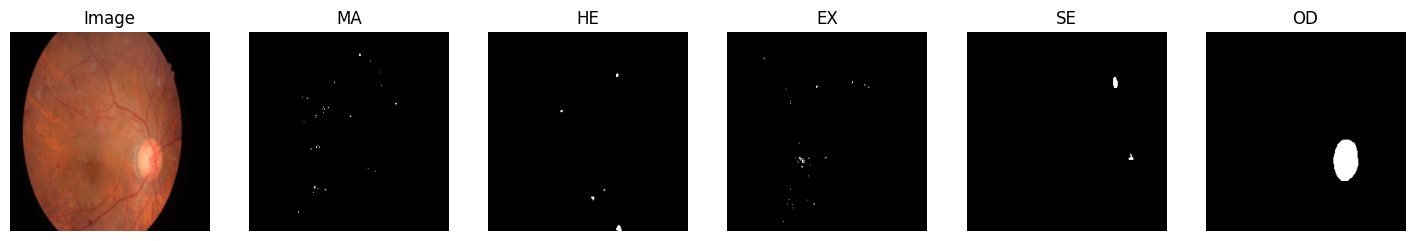

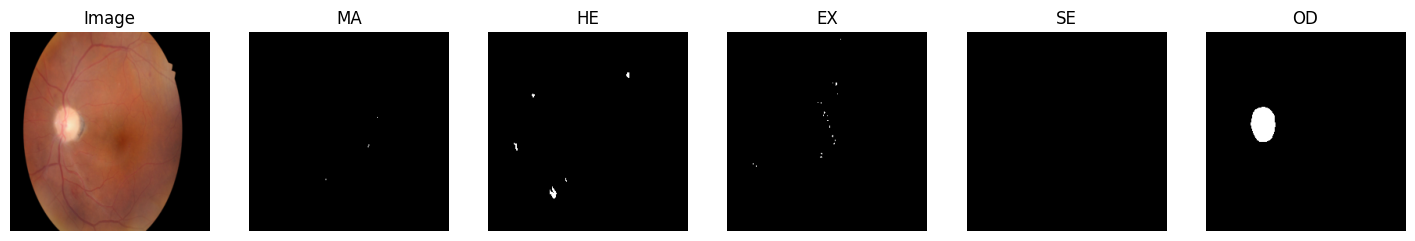

In [17]:
import json
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

# ---------------------------
# CONFIGURATION
# ---------------------------
IMAGE_SIZE = (256, 256)
JSON_PATH = "/content/segmentation_metadata_train.json"
CLASS_NAMES = ['MA', 'HE', 'EX', 'SE', 'OD']

# ---------------------------
# DATASET CLASS
# ---------------------------
class IDRiDDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.classes = CLASS_NAMES
        self.image_tf = T.Compose([
            T.Resize(IMAGE_SIZE),
            T.ToTensor(),
            T.Normalize(mean=[0.5]*3, std=[0.5]*3)
        ])
        self.mask_tf = T.Resize(IMAGE_SIZE, interpolation=Image.NEAREST)

    def __getitem__(self, idx):
        sample = self.data[idx]
        img = Image.open(sample['image']).convert('RGB')
        img = self.image_tf(img)

        masks = []
        for cls in self.classes:
            mask_path = sample.get(cls)
            if mask_path is None:
                mask = Image.fromarray(np.zeros(IMAGE_SIZE, dtype=np.uint8))
            else:
                mask = Image.open(mask_path).convert('L')
            mask = self.mask_tf(mask)
            mask = torch.from_numpy(np.array(mask)).float() / 255.0
            masks.append(mask)

        return img, torch.stack(masks)

    def __len__(self):
        return len(self.data)

# ---------------------------
# LOAD JSON
# ---------------------------
def load_data(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

# ---------------------------
# VISUALIZE A SINGLE BATCH
# ---------------------------
def visualize_batch(images, masks):
    for i in range(images.size(0)):
        image = images[i].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5
        fig, axs = plt.subplots(1, len(CLASS_NAMES) + 1, figsize=(18, 3))
        canvas = FigureCanvas(fig)
        axs[0].imshow(image)
        axs[0].set_title("Image")
        axs[0].axis("off")
        for j in range(len(CLASS_NAMES)):
            axs[j+1].imshow(masks[i, j].cpu(), cmap='gray')
            axs[j+1].set_title(CLASS_NAMES[j])
            axs[j+1].axis("off")
        plt.show()
        plt.close()

# ---------------------------
# MAIN
# ---------------------------
if __name__ == "__main__":
    data = load_data(JSON_PATH)
    dataset = IDRiDDataset(data)
    loader = DataLoader(dataset, batch_size=2, shuffle=True)

    images, masks = next(iter(loader))
    visualize_batch(images, masks)

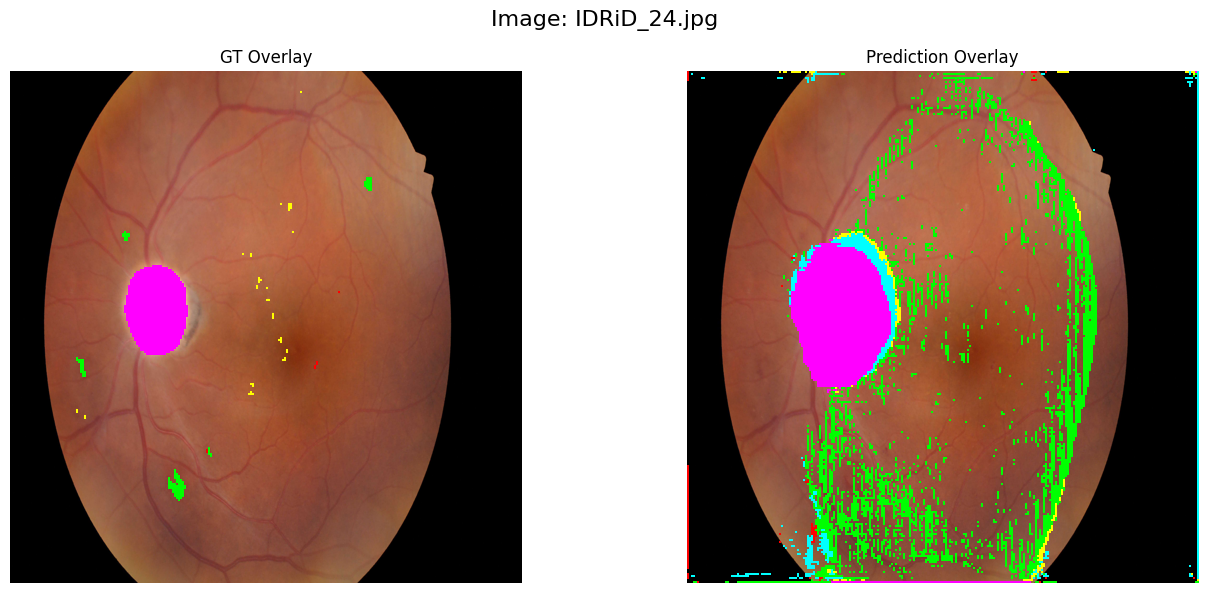

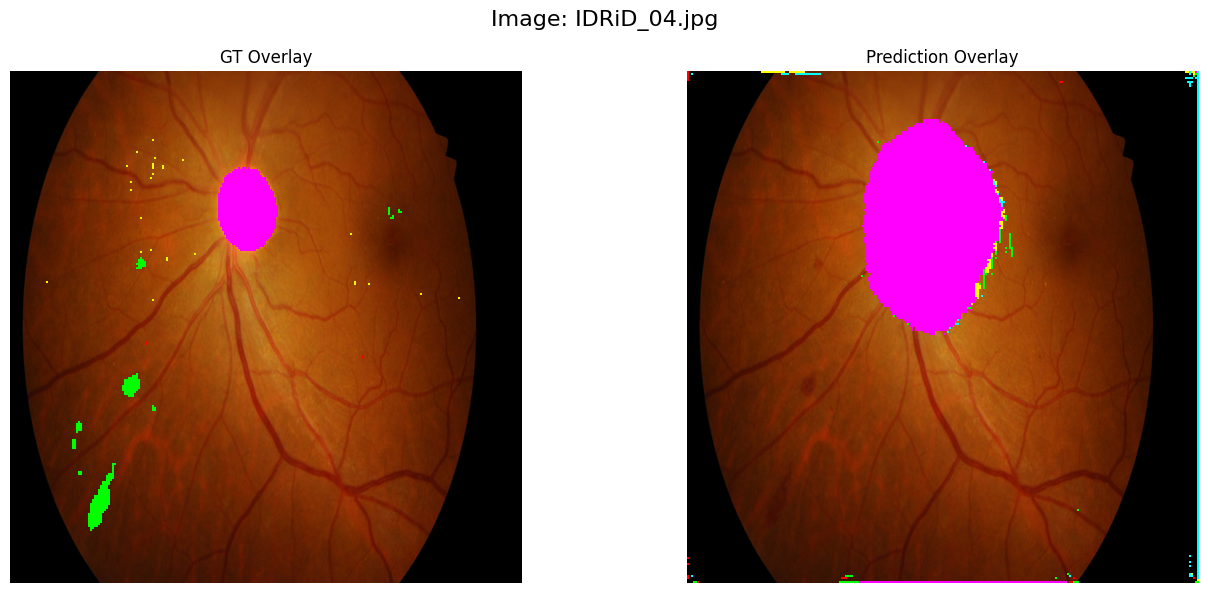

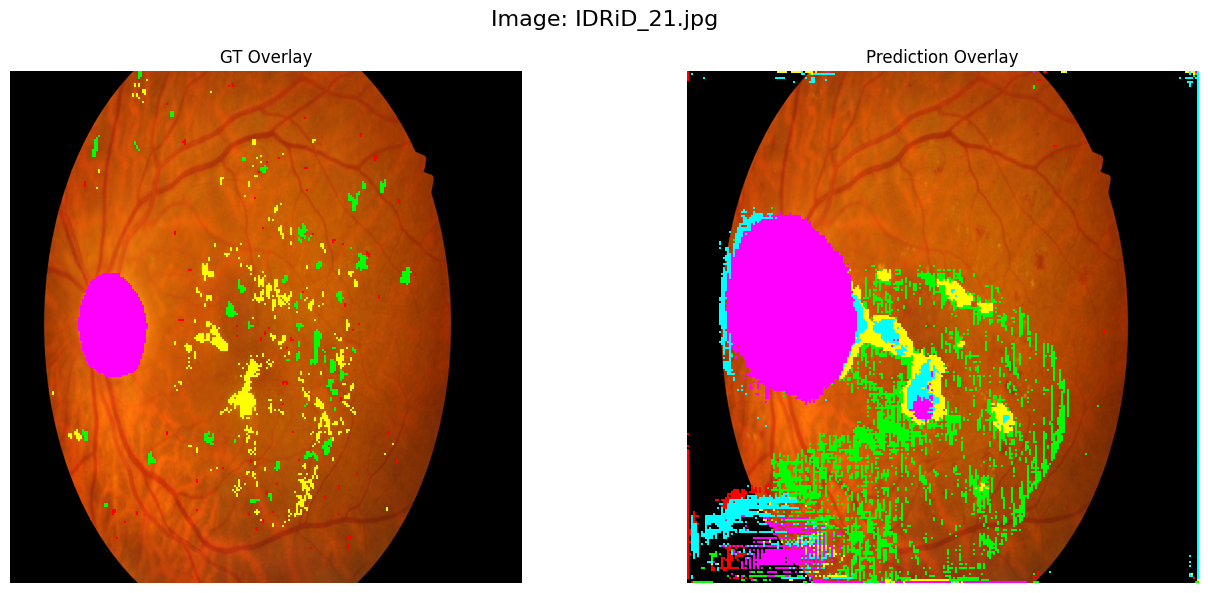

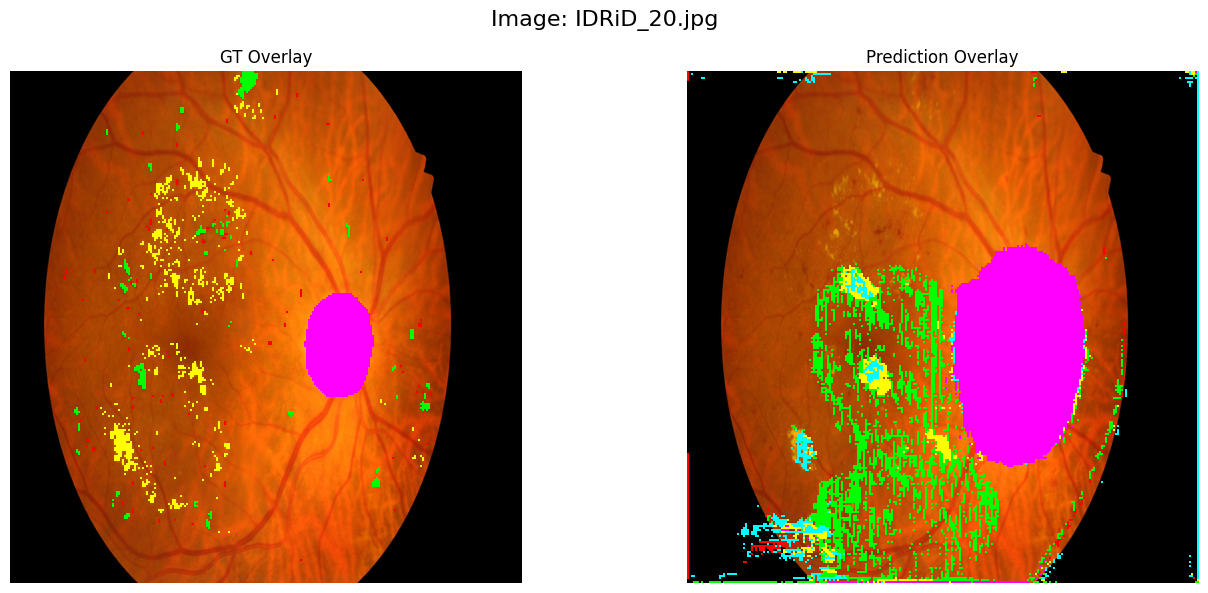

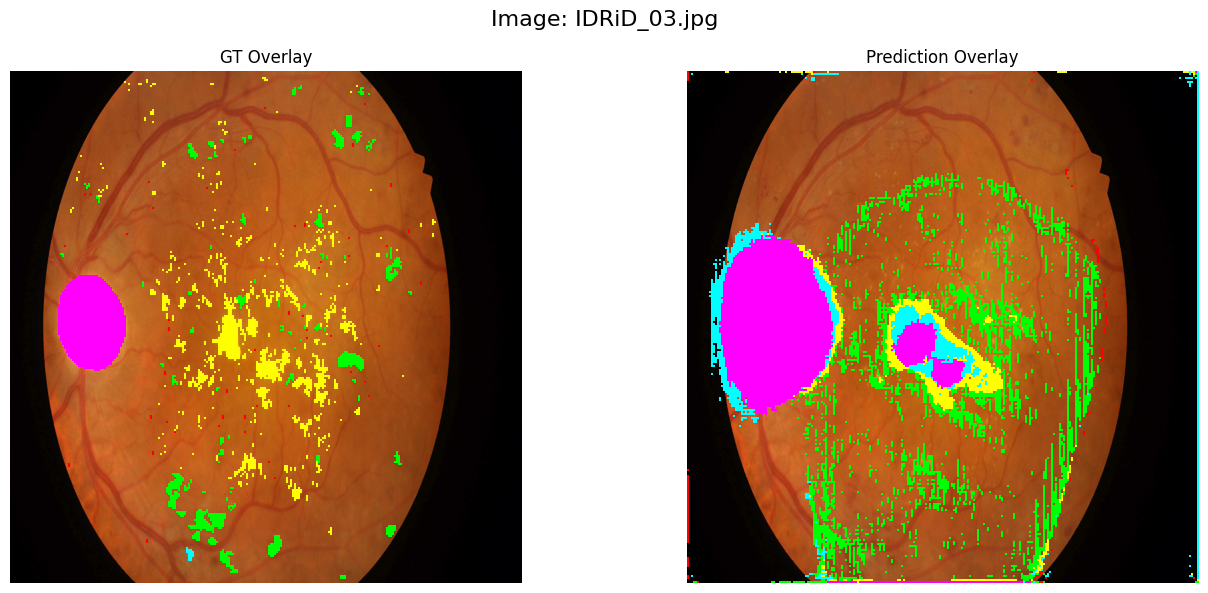

In [24]:
import os
import random
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset
import segmentation_models_pytorch as smp
import json
from pathlib import Path

# ---------------------------
# CONFIGURATION
# ---------------------------
MODEL_PATH = "/content/drive/MyDrive/best_model_combined_loss2.pth"
JSON_PATH = "/content/segmentation_metadata_train.json"
IMAGE_SIZE = (256, 256)
DISPLAY_SIZE = (512, 512)
NUM_CLASSES = 5
CLASS_NAMES = ['MA', 'HE', 'EX', 'SE', 'OD']
BATCH_SIZE = 1
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEG_COLORS = {
    'MA': (255, 0, 0),      # Red
    'HE': (0, 255, 0),      # Green
    'EX': (255, 255, 0),    # Yellow
    'SE': (0, 255, 255),    # Cyan
    'OD': (255, 0, 255)     # Magenta
}

# ---------------------------
# TRANSFORM
# ---------------------------
transform = T.Compose([
    T.Resize(IMAGE_SIZE),
    T.ToTensor(),
    T.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

mask_transform = T.Resize(IMAGE_SIZE, interpolation=Image.NEAREST)

# ---------------------------
# DATASET CLASS
# ---------------------------
class IDRiDDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, idx):
        sample = self.data[idx]
        image = Image.open(sample['image']).convert('RGB')
        img_tensor = transform(image)

        masks = []
        for cls in CLASS_NAMES:
            mask_path = sample.get(cls)
            if mask_path is None:
                mask = Image.fromarray(np.zeros(IMAGE_SIZE, dtype=np.uint8))
            else:
                mask = Image.open(mask_path).convert('L')
            mask = mask_transform(mask)
            arr = np.array(mask).astype(np.float32)
            arr = (arr > 0).astype(np.float32)
            masks.append(torch.from_numpy(arr))

        return img_tensor, torch.stack(masks), image.resize(DISPLAY_SIZE), sample

    def __len__(self):
        return len(self.data)

# ---------------------------
# LOAD MODEL
# ---------------------------
def load_model():
    model = smp.Unet("resnet50", encoder_weights=None, in_channels=3, classes=NUM_CLASSES)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    return model.to(DEVICE).eval()

# ---------------------------
# PREDICT AND VISUALIZE
# ---------------------------
def visualize_gt_and_preds(model, loader, num_samples=5):
    indices = random.sample(range(len(loader.dataset)), num_samples)

    for i in indices:
        image_tensor, gt_mask, original_image, sample = loader.dataset[i]
        input_tensor = image_tensor.unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            output = model(input_tensor)
            probs = torch.sigmoid(output).squeeze(0).cpu().numpy()
            preds = (probs > 0.5).astype(np.uint8)

        overlay_gt = np.array(original_image.copy())
        overlay_pred = np.array(original_image.copy())

        for j, cls in enumerate(CLASS_NAMES):
            color = SEG_COLORS[cls]
            gt_mask_resized = np.array(gt_mask[j].numpy().astype(np.uint8))
            gt_mask_resized = Image.fromarray(gt_mask_resized * 255).resize(DISPLAY_SIZE, Image.NEAREST)
            pred_mask_resized = Image.fromarray(preds[j] * 255).resize(DISPLAY_SIZE, Image.NEAREST)

            gt_mask_np = np.array(gt_mask_resized) > 0
            pred_mask_np = np.array(pred_mask_resized) > 0

            overlay_gt[gt_mask_np] = color
            overlay_pred[pred_mask_np] = color

        # Plot both overlays side by side
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))
        axs[0].imshow(overlay_gt)
        axs[0].set_title("GT Overlay")
        axs[0].axis("off")

        axs[1].imshow(overlay_pred)
        axs[1].set_title("Prediction Overlay")
        axs[1].axis("off")

        plt.suptitle(f"Image: {Path(sample['image']).name}", fontsize=16)
        plt.tight_layout()
        plt.show()

# ---------------------------
# MAIN
# ---------------------------
if __name__ == "__main__":
    with open(JSON_PATH, 'r') as f:
        data = json.load(f)

    dataset = IDRiDDataset(data)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

    model = load_model()
    visualize_gt_and_preds(model, loader, num_samples=5)